# DKOM 2019
We show three areas of innovation.  The purpose is to demonstrate how data scientists can explore and perform machine learning tasks on large data sets that are stored in HANA.  We show the power of pushing processing power closer to where the data exists.  The benefits of using the power of HANA are:
<li>Performance:  We see orders of magnitude performance gains and it only gets better when data sets are large.</li>
<li>Security:  Since the data is all in HANA and processing done there, all the security measures are enforced along with the data.</li>
<br>
<br>
From a data scientist point of view, they use Python and Python like APIs that they are comfortable with.
<br>
<br>
We will cover the following:
<li><b>Dataframes:</b>A reference to a relation in HANA.  No need for deep SQL knowledge.</li>
<li><b>HANA ML API:</b>Exploit HANA's ML capabilities using a SciKit type of Python interface.</li>
<li><b>Exploratory Data Analysis and Visualization:</b>Analyze large data sets without the performance penalty or running out of resources on the client</li>

# Dataframes
The SAP HANA Python Client API for machine learning algorithms (Python Client API for ML) provides a set of client-side Python functions for accessing and querying SAP HANA data, and a set of functions for developing machine learning models.

The Python Client API for ML consists of two main parts:

<li>A set of machine learning APIs for different algorithms.</li>
<li>The SAP HANA dataframe, which provides a set of methods for analyzing data in SAP HANA without bringing that data to the client.</li>

This library uses the SAP HANA Python driver (hdbcli) to connect to and access SAP HANA.
<br>
<br>
<img src="images/highlevel_overview2_new.png" title="Python API Overview" style="float:left;" width="300" height="50" />
<br>
A dataframe represents a table (or any SQL statement).  Most operations on a dataframe are designed to not bring data back from the database unless explicitly asked for.

In [1]:
from hana_ml import dataframe
import logging

## Setup connection and data sets
Let us load some data into a HANA table.  The data is loaded into 4 tables - full set, test set, training set, and the validation set:DBM2_RFULL_TBL, DBM2_RTEST_TBL, DBM2_RTRAINING_TBL, DBM2_RVALIDATION_TBL.

The data is related with direct marketing campaigns of a Portuguese banking institution. More information regarding the data set is at https://archive.ics.uci.edu/ml/datasets/bank+marketing#. For tutorials use only.

To do that, a connection is created and passed to the loader.  There is a config file, <b>config/e2edata.ini</b> that controls the connection parameters.  Please edit it to point to your hana instance.

In [2]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_bank_data(connection_context, force=False, batch_size=50000)

Table DBM2_RFULL_TBL exists and data exists


### Simple DataFrame
A dataframe is a reference to a relation.  This can be a table, view, or any relation from a SQL statement
<table align="left"><tr><td>
</td><td><img src="images/Dataframes_1.png" style="float:left;" width="600" height="400" /></td></tr></table>
<br>
<b>Let's take a look at a dataframe created using our training table.</b>
<br>

In [3]:
dataset = connection_context.table(training_tbl)
print(dataset.select_statement)

SELECT * FROM "DBM2_RTRAINING_TBL"


In [4]:
print(type(dataset))

<class 'hana_ml.dataframe.DataFrame'>


### Bring data to client
#### Fetch 5 rows into client as a <b>Pandas Dataframe</b>

In [5]:
dataset.head(5).collect()

,ID,AGE,JOB,MARITAL,EDUCATION,DBM_DEFAULT,HOUSING,LOAN,CONTACT,DBM_MONTH,...,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,EURIBOR3M,NREMPLOYED,LABEL
0,8746,54,admin.,married,high.school,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228,no
1,8041,36,housemaid,married,high.school,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228,no
2,8214,38,technician,married,basic.9y,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228,no
3,9441,42,blue-collar,married,basic.9y,unknown,no,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228,no
4,8272,39,admin.,married,university.degree,no,no,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228,no


## SQL Operations
We now show simple SQL operations.  No extensive SQL knowledge is needed.

### Projection
<img src="images/Projection.png" style="float:left;" width="150" height="750" />

In [6]:
dsp = dataset.select("ID", "AGE", "JOB", ('"AGE"*2', "TWICE_AGE"))
dsp.head(5).collect()  # collect() brings data to the client)

,ID,AGE,JOB,TWICE_AGE
0,8746,54,admin.,108
1,8041,36,housemaid,72
2,8214,38,technician,76
3,9441,42,blue-collar,84
4,8272,39,admin.,78


### Filtering Data
<img src="images/Filter.png" style="float:left;" width="200" height="100" />

In [7]:
dataset.filter('AGE > 60').head(10).collect()

,ID,AGE,JOB,MARITAL,EDUCATION,DBM_DEFAULT,HOUSING,LOAN,CONTACT,DBM_MONTH,...,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,EURIBOR3M,NREMPLOYED,LABEL
0,29830,69,retired,divorced,basic.4y,no,no,no,cellular,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099,no
1,36021,61,unknown,single,basic.4y,no,yes,no,cellular,may,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099,no
2,30030,64,retired,married,university.degree,no,yes,no,cellular,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099,no
3,28514,61,retired,married,university.degree,no,yes,no,cellular,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099,yes
4,28726,69,retired,married,unknown,no,no,no,cellular,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.410,5099,no
5,30134,79,retired,married,basic.9y,no,yes,no,cellular,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099,yes
6,30391,71,retired,divorced,basic.4y,no,yes,no,telephone,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099,no
7,35862,66,housemaid,married,high.school,no,yes,no,cellular,may,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.259,5099,no
8,30242,81,retired,married,professional.course,no,no,no,cellular,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099,no
9,35962,61,retired,married,basic.9y,no,no,no,cellular,may,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.264,5099,no


### Sorting
<img src="images/Sort.png" style="float:left;" width="200" height="100" />

In [8]:
dataset.filter('AGE>60').sort(['AGE']).head(2).collect()

,ID,AGE,JOB,MARITAL,EDUCATION,DBM_DEFAULT,HOUSING,LOAN,CONTACT,DBM_MONTH,...,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,EURIBOR3M,NREMPLOYED,LABEL
0,36021,61,unknown,single,basic.4y,no,yes,no,cellular,may,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099,no
1,28514,61,retired,married,university.degree,no,yes,no,cellular,apr,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099,yes


### Grouping Data
<img src="images/Grouping.png" style="float:left;" width="300" height="200" />

In [9]:
dataset.agg([('count', 'AGE', 'COUNT_OF_AGE')], group_by='AGE').head(4).collect()

,AGE,COUNT_OF_AGE
0,17,4
1,18,10
2,19,18
3,20,30


### Simple Joins
<img src="images/Join.png" style="float:left;" width="300" height="200" />

In [10]:
ds1 = dataset.select(["ID", "AGE"])
ds2 = dataset.select(["ID", "JOB"])
condition = '{}."ID"={}."ID"'.format(ds1.quoted_name, ds2.quoted_name)
dsj = ds1.join(ds2, condition)
dsj.select_statement

'SELECT * FROM (SELECT "ID", "AGE" FROM (SELECT * FROM "DBM2_RTRAINING_TBL") AS "DT_3") AS "DT_15" INNER JOIN (SELECT "ID", "JOB" FROM (SELECT * FROM "DBM2_RTRAINING_TBL") AS "DT_3") AS "DT_16" ON "DT_15"."ID"="DT_16"."ID"'

### Describing a dataframe
<img src="images/Describe.png" style="float:left;" width="300" height="200" />

In [11]:
dataset.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,ID,20594,20594,0,20598.859911,11895.677439,1.000,41187.000,20569.000,10268.250,10268.000,20568.500,20568.000,30885.250,30886.000
1,AGE,20594,76,0,40.088375,10.386609,17.000,98.000,38.000,32.000,32.000,38.000,38.000,47.000,47.000
2,DURATION,20594,1326,0,260.616199,265.660606,0.000,4918.000,180.000,102.000,102.000,180.000,180.000,321.000,321.000
3,CAMPAIGN,20594,40,0,2.573662,2.761350,1.000,43.000,2.000,1.000,1.000,2.000,2.000,3.000,3.000
4,PDAYS,20594,25,0,961.629795,188.985753,0.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000
5,PREVIOUS,20594,8,0,0.173691,0.493915,0.000,7.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,EMP_VAR_RATE,20594,10,0,0.082325,1.572978,-3.400,1.400,1.100,-1.800,-1.800,1.100,1.100,1.400,1.400
7,CONS_PRICE_IDX,20594,26,0,93.576548,0.580561,92.201,94.767,93.749,93.075,93.075,93.749,93.749,93.994,93.994
8,CONS_CONF_IDX,20594,26,0,-40.476988,4.635267,-50.800,-26.900,-41.800,-42.700,-42.700,-41.800,-41.800,-36.400,-36.400
9,EURIBOR3M,20594,302,0,3.620535,1.736291,0.634,5.045,4.857,1.344,1.344,4.857,4.857,4.961,4.961


In [12]:
dataset.describe().select_statement

'SELECT * FROM (SELECT "SimpleStats".*, "Percentiles"."25_percent_cont", "Percentiles"."25_percent_disc", "Percentiles"."50_percent_cont", "Percentiles"."50_percent_disc", "Percentiles"."75_percent_cont", "Percentiles"."75_percent_disc" FROM (select \'ID\' as "column", COUNT("ID") as "count", COUNT(DISTINCT "ID") as "unique", SUM(CASE WHEN "ID" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("ID")) as "mean", STDDEV("ID") as "std", MIN("ID") as "min", MAX("ID") as "max", MEDIAN("ID") as "median" FROM (SELECT * FROM "DBM2_RTRAINING_TBL") AS "DT_3" UNION ALL select \'AGE\' as "column", COUNT("AGE") as "count", COUNT(DISTINCT "AGE") as "unique", SUM(CASE WHEN "AGE" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("AGE")) as "mean", STDDEV("AGE") as "std", MIN("AGE") as "min", MAX("AGE") as "max", MEDIAN("AGE") as "median" FROM (SELECT * FROM "DBM2_RTRAINING_TBL") AS "DT_3" UNION ALL select \'DURATION\' as "column", COUNT("DURATION") as "count", COUNT(DISTINCT "DURATION") as "uniq

# ML API Wrapping Predictive Analytics Library

## Classification - Logistic Regression Example
### Bank dataset to determine if a customer would buy a CD
The data is related with direct marketing campaigns of a Portuguese banking institution.  The marketing campaigns were based on phone calls.  A number of features such as age, kind of job, marital status, education level, credit default, existence of housing loan, etc. were considered.  The classification goal is to predict if the client will subscribe (yes/no) a term deposit.

More information regarding the data set is at https://archive.ics.uci.edu/ml/datasets/bank+marketing#. For tutorials use only.

<font color='blue'>__ The objective is to demonstrate the use of logistic regression and to tune hyperparameters enet_lamba and enet_alpha. __</font>

### Attribute Information:

#### Input variables:
##### Bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

##### Related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### Other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

##### Social and economic context attributes:
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')


### Load the data set and create data frames

In [13]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import linear_model
from hana_ml.algorithms.pal import clustering
from hana_ml.algorithms.pal import trees
import numpy as np
import matplotlib.pyplot as plt
import logging
from IPython.core.display import Image, display

In [14]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_bank_data(connection_context, force=False, batch_size=50000)

Table DBM2_RFULL_TBL exists and data exists


In [15]:
full_set = connection_context.table(full_tbl)
training_set = connection_context.table(training_tbl)
validation_set = connection_context.table(validation_tbl)
test_set = connection_context.table(test_tbl)

### Let us look at some rows

In [16]:
training_set.head(5).collect()

,ID,AGE,JOB,MARITAL,EDUCATION,DBM_DEFAULT,HOUSING,LOAN,CONTACT,DBM_MONTH,...,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,EURIBOR3M,NREMPLOYED,LABEL
0,8746,54,admin.,married,high.school,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228,no
1,8041,36,housemaid,married,high.school,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228,no
2,8214,38,technician,married,basic.9y,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228,no
3,9441,42,blue-collar,married,basic.9y,unknown,no,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228,no
4,8272,39,admin.,married,university.degree,no,no,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228,no


# Create Model and Tune Hyperparameters
Try different hyperparameters and see what parameter is best.
The results are stored in a list called res which can then be used to visualize the results.

_The variable "quick" is to run the tests for only a few values to avoid running the code below for a long time._


In [17]:
features = ['AGE','JOB','MARITAL','EDUCATION','DBM_DEFAULT', 'HOUSING','LOAN','CONTACT','DBM_MONTH','DAY_OF_WEEK','DURATION','CAMPAIGN','PDAYS','PREVIOUS','POUTCOME','EMP_VAR_RATE','CONS_PRICE_IDX','CONS_CONF_IDX','EURIBOR3M','NREMPLOYED']
label = "LABEL"

In [18]:
quick = True
enet_lambdas = np.linspace(0.01,0.02, endpoint=False, num=1) if quick else np.append(np.linspace(0.01,0.02, endpoint=False, num=4), np.linspace(0.02,0.02, num=5))
enet_alphas = np.linspace(0, 1, num=4) if quick else np.linspace(0, 1, num=40)
res = []
for enet_alpha in enet_alphas:
    for enet_lambda in enet_lambdas:
        lr = linear_model.LogisticRegression(solver='Cyclical', tol=0.000001, max_iter=10000, 
                                             stat_inf=True,pmml_export='multi-row', enet_lambda=enet_lambda, enet_alpha=enet_alpha,
                                             class_map0='no', class_map1='yes')
        lr.fit(training_set, features=features, label=label)
        accuracy_val = lr.score(validation_set, 'ID', features, label)
        res.append((enet_alpha, enet_lambda, accuracy_val, lr.coef_))

## Graph the results
Plot the accuracy on the validation set against the hyperparameters.

This is only done if all the combinations are tried.

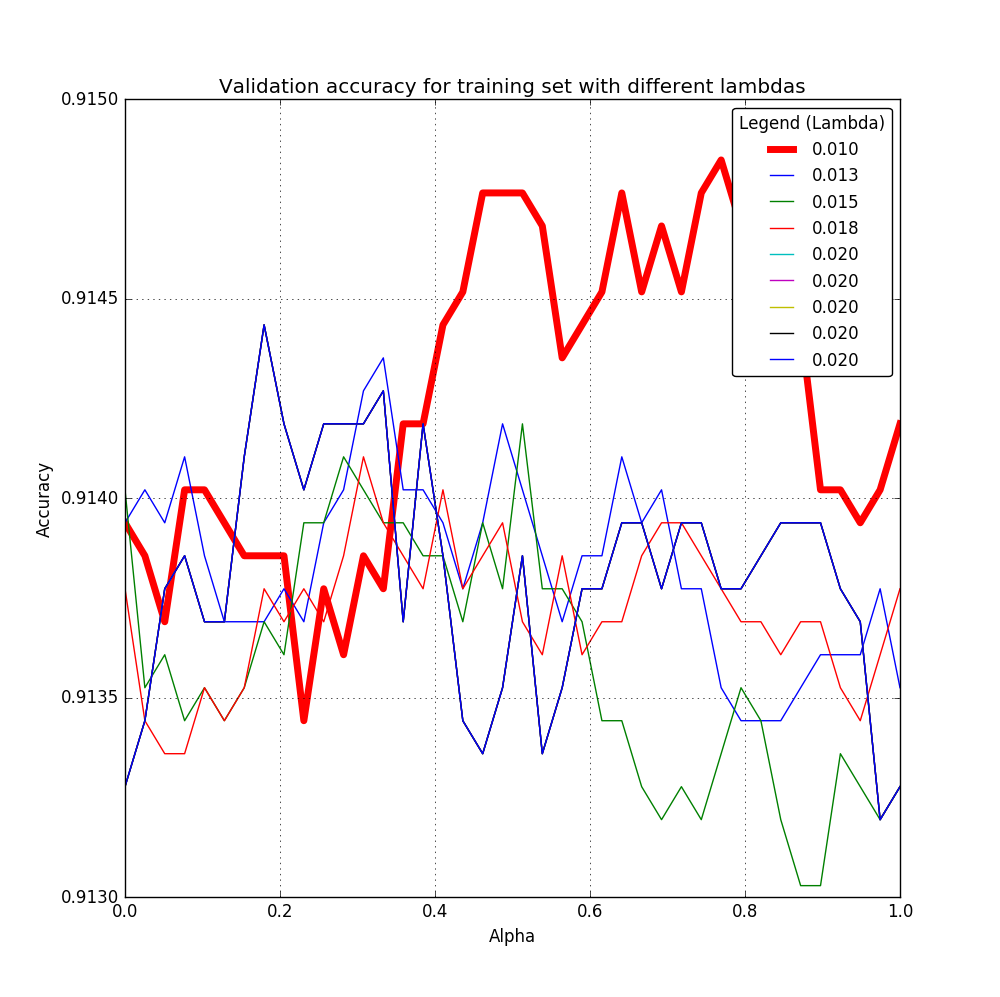

Best accuracy: 0.9148
Value of alpha for maximum accuracy: 0.769
Value of lambda for maximum accuracy: 0.010


In [19]:
%matplotlib inline
if not quick:
    arry = np.asarray(res)
    fig = plt.figure(figsize=(10,10))
    plt.title("Validation accuracy for training set with different lambdas")
    ax = fig.add_subplot(111)
    most_accurate_lambda = arry[np.argmax(arry[:,2]),1]
    best_accuracy_arg = np.argmax(arry[:,2])
    for lamda in enet_lambdas:
        if lamda == most_accurate_lambda:
            ax.plot(arry[arry[:,1]==lamda][:,0], arry[arry[:,1]==lamda][:,2], label="%.3f" % round(lamda,3), linewidth=5, c='r')
        else:
            ax.plot(arry[arry[:,1]==lamda][:,0], arry[arry[:,1]==lamda][:,2], label="%.3f" % round(lamda,3))
    plt.legend(loc=1, title="Legend (Lambda)", fancybox=True, fontsize=12)
    ax.set_xlabel('Alpha', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()
    print("Best accuracy: %.4f" % (arry[best_accuracy_arg][2]))
    print("Value of alpha for maximum accuracy: %.3f\nValue of lambda for maximum accuracy: %.3f\n" % (arry[best_accuracy_arg][0], arry[best_accuracy_arg][1]))
else:
    display(Image('images/bank-data-hyperparameter-tuning.png', width=800, unconfined=True))
    print("Best accuracy: 0.9148")
    print("Value of alpha for maximum accuracy: 0.769")
    print("Value of lambda for maximum accuracy: 0.010")

# Predictions on test set
Let us do the predictions on the test set using these values of alpha and lambda

In [20]:
alpha = 0.769
lamda = 0.01
lr = linear_model.LogisticRegression(solver='Cyclical', tol=0.000001, max_iter=10000, 
                                       stat_inf=True,pmml_export='multi-row', enet_lambda=lamda, enet_alpha=alpha,
                                       class_map0='no', class_map1='yes')
lr.fit(training_set, features=features, label=label)

## Look at the predictions

In [21]:
result_df = lr.predict(test_set, 'ID')
result_df.filter('"CLASS"=\'no\'').head(5).collect()

,ID,CLASS,PROBABILITY
0,3390,no,0.337931
1,1129,no,0.047556
2,6303,no,0.046349
3,928,no,0.014776
4,5533,no,0.062730


## What about the final score?

In [22]:
lr.score(test_set, 'ID')

0.9126

# KMeans Clustering Example

A data set that identifies different types of iris's is used to demonstrate KMeans in SAP HANA.
## Iris Data Set
The data set used is from University of California, Irvine (https://archive.ics.uci.edu/ml/datasets/iris). For tutorials use only. This data set contains attributes of a plant iris.  There are three species of Iris plants.
<table>
<tr><td>Iris Setosa</td><td><img src="images/Iris_setosa.jpg" title="Iris Sertosa" style="float:left;" width="300" height="50" /></td>
<td>Iris Versicolor</td><td><img src="images/Iris_versicolor.jpg" title="Iris Versicolor" style="float:left;" width="300" height="50" /></td>
<td>Iris Virginica</td><td><img src="images/Iris_virginica.jpg" title="Iris Virginica" style="float:left;" width="300" height="50" /></td></tr>
</table>

The data contains the following attributes for various flowers:
<table align="left"><tr><td>
<li align="top">sepal length in cm</li>
<li align="left">sepal width in cm</li>
<li align="left">petal length in cm</li>
<li align="left">petal width in cm</li>
</td><td><img src="images/sepal_petal.jpg" style="float:left;" width="200" height="40" /></td></tr></table>

Although the flower is identified in the data set, we will cluster the data set into 3 clusters since we know there are three different flowers.  The hope is that the cluster will correspond to each of the flowers.

A different notebook will use a classification algorithm to predict the type of flower based on the sepal and petal dimensions.

### Load the data set and create data frames

In [23]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import clustering
import numpy as np
import pandas as pd
import logging
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [24]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_iris_data(connection_context, force=False, batch_size=50000)

Table IRIS_DATA_FULL_TBL exists and data exists


In [25]:
full_set = connection_context.table(full_tbl)

### Let's check how many SPECIES are in the data set.

In [26]:
full_set.distinct("SPECIES").collect()

,SPECIES
0,Iris-setosa
1,Iris-versicolor
2,Iris-virginica


# Create Model
The lines below show the ease with which clustering can be done.

Set up the features and labels for the model and create the model

In [27]:
features = ['SEPALLENGTHCM','SEPALWIDTHCM','PETALLENGTHCM','PETALWIDTHCM']
label = ['SPECIES']

In [28]:
kmeans = clustering.KMeans(thread_ratio=0.2, n_clusters=3, distance_level='euclidean', 
                           max_iter=100, tol=1.0E-6, category_weights=0.5, normalization='min_max')
predictions = kmeans.fit_predict(full_set, 'ID', features).collect()
predictions.head(5)

,ID,CLUSTER_ID,DISTANCE,SLIGHT_SILHOUETTE
0,1,0,0.197969,0.468456
1,2,1,0.373786,0.680851
2,3,1,0.159394,0.789202
3,4,1,0.173900,0.786873
4,5,1,0.205616,0.712051


# Plot the data

In [29]:
def plot_kmeans_results(data_set, features, predictions):
    # use this to estimate what each cluster_id represents in terms of flowers
    # ideal would be 50-50-50 for each flower, so we can see there are some mis clusterings
    class_colors = {0: 'r', 1: 'b', 2: 'k'}
    predictions_colors = [class_colors[p] for p in predictions['CLUSTER_ID'].values]

    red = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='r', label='Iris-virginica', markersize=10, alpha=0.9)
    blue = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='b', label='Iris-versicolor', markersize=10, alpha=0.9)
    black = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='k', label='Iris-setosa', markersize=10, alpha=0.9)

    for x, y in itertools.combinations(features, 2):
        plt.figure(figsize=(10,5))
        plt.scatter(full_set[[x]].collect(), data_set[[y]].collect(), c=predictions_colors, alpha=0.6, s=70)
        plt.grid()
        plt.xlabel(x, fontsize=15)
        plt.ylabel(y, fontsize=15)
        plt.tick_params(labelsize=15)
        plt.legend(handles=[red, blue, black])
        plt.show()

    %matplotlib inline
    #above allows interactive 3d plot

    sizes=10
    for x, y, z in itertools.combinations(features, 3):
        fig = plt.figure(figsize=(8,5))

        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(data_set[[x]].collect(), data_set[[y]].collect(), data_set[[z]].collect(), c=predictions_colors, s=70)
        plt.grid()

        ax.set_xlabel(x, labelpad=sizes, fontsize=sizes)
        ax.set_ylabel(y, labelpad=sizes, fontsize=sizes)
        ax.set_zlabel(z, labelpad=sizes, fontsize=sizes)
        ax.tick_params(labelsize=sizes)
        plt.legend(handles=[red, blue, black])
        plt.show()

In [30]:
print(pd.concat([predictions, full_set[['SPECIES']].collect()], axis=1).groupby(['SPECIES','CLUSTER_ID']).size())


SPECIES          CLUSTER_ID
Iris-setosa      0             18
                 2             32
Iris-versicolor  0              4
                 1             46
Iris-virginica   1             50
dtype: int64


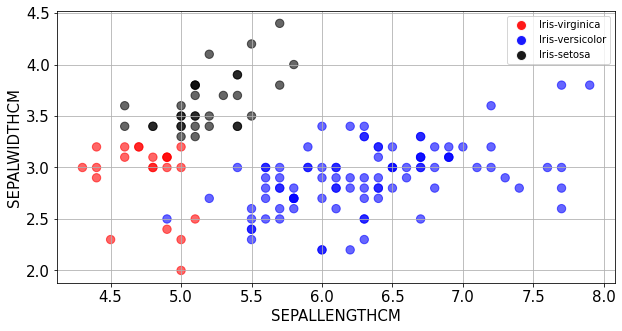

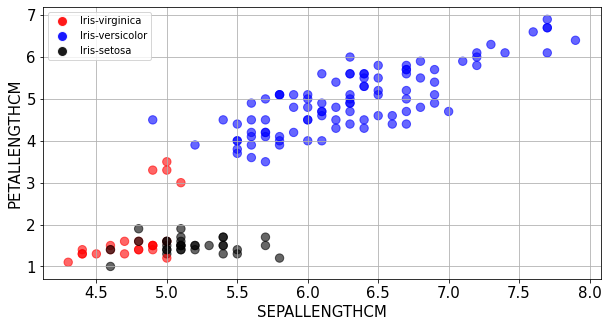

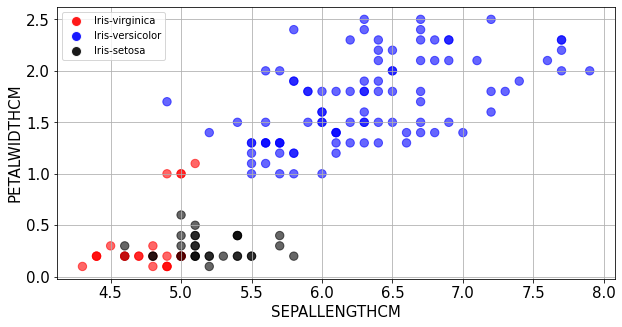

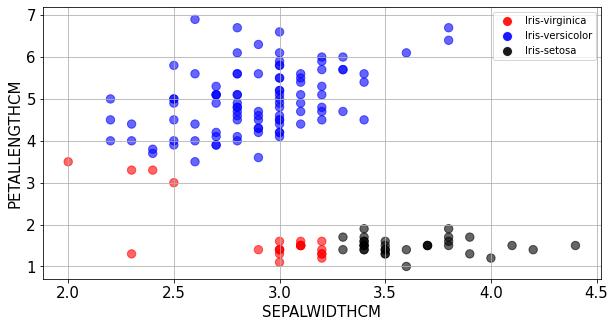

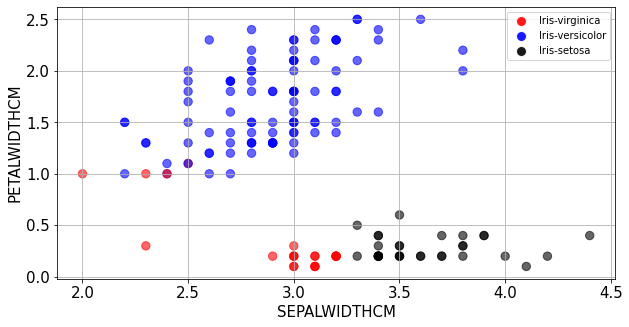

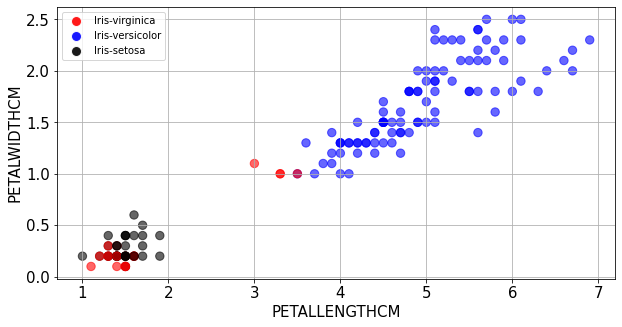

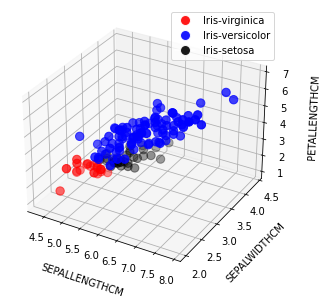

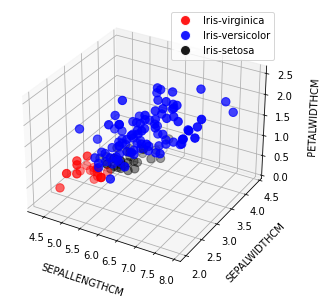

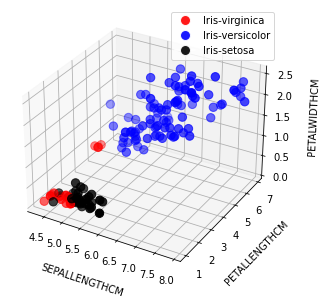

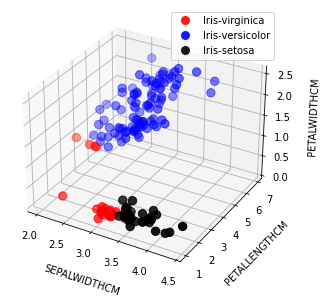

In [31]:
%matplotlib inline
plot_kmeans_results(full_set, features, predictions)

# Exploratory Data Analysis and Visualization

## Titanic Data Set (~1K rows)
This dataset is from https://github.com/awesomedata/awesome-public-datasets/tree/master/Datasets For tutorials use only.

In [32]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import trees
from hana_ml.visualizers.eda import EDAVisualizer as eda
import pandas as pd
import matplotlib.pyplot as plt
import time
from hana_ml.visualizers.eda import EDAVisualizer

In [33]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_titanic_data(connection_context, force=True, batch_size=50000)

Creating table PAL_TEST.TITANIC_FULL_TBL
Creating table PAL_TEST.TITANIC_TRAIN_TBL
Creating table PAL_TEST.TITANIC_VALIDATION_TBL
Creating table PAL_TEST.TITANIC_TEST_TBL
Data Loaded:100%


In [34]:
# Create the HANA Dataframe (df_train) and point to the training table.
data = connection_context.table(full_tbl)
data = data.fillna(25, ['AGE'])
data.head(5).collect()
data.dtypes()

[('PASSENGER_ID', 'INT', 10, 10, 10, 0),
 ('PCLASS', 'INT', 10, 10, 10, 0),
 ('NAME', 'NVARCHAR', 128, 128, 128, 0),
 ('SEX', 'NVARCHAR', 6, 6, 6, 0),
 ('AGE', 'DOUBLE', 15, 15, 15, 0),
 ('SIBSP', 'INT', 10, 10, 10, 0),
 ('PARCH', 'INT', 10, 10, 10, 0),
 ('TICKET', 'NVARCHAR', 18, 18, 18, 0),
 ('FARE', 'DOUBLE', 15, 15, 15, 0),
 ('CABIN', 'NVARCHAR', 15, 15, 15, 0),
 ('EMBARKED', 'NVARCHAR', 1, 1, 1, 0),
 ('SURVIVED', 'INT', 10, 10, 10, 0)]

### Histogram plot for AGE distribution

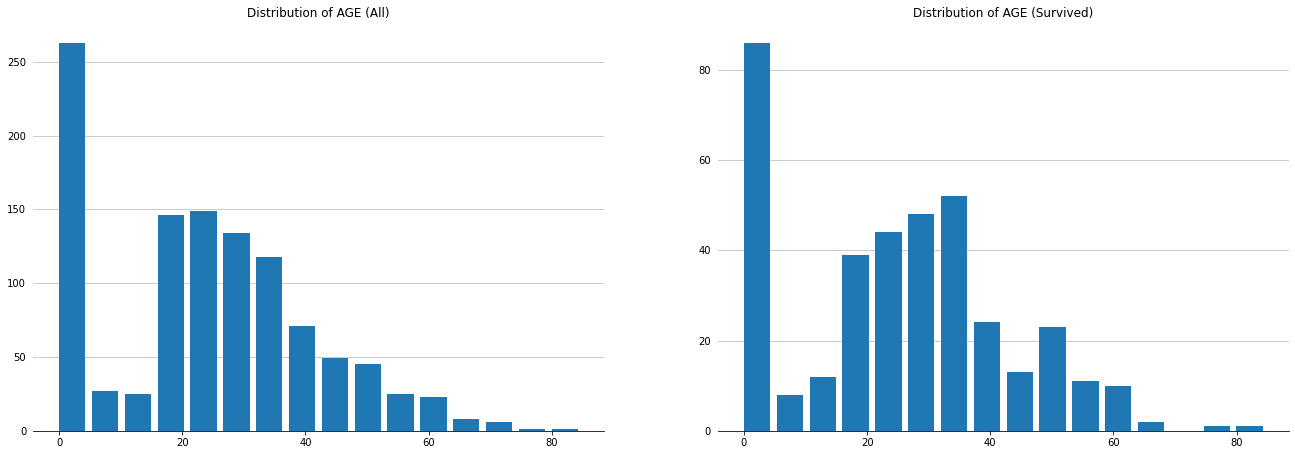

Time: 7.54s.  Time taken to do this by getting the data from the server was 0.86s


In [35]:
bins=15
f = plt.figure(figsize=(bins*1.5, bins*0.5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
start = time.time()
eda = EDAVisualizer(ax1)
ax1, dist_data1 = eda.distribution_plot(data, column="AGE", bins=bins, title="Distribution of AGE (All)")
eda = EDAVisualizer(ax2)
ax2, dist_data2 = eda.distribution_plot(data.filter('SURVIVED=1'), column="AGE", bins=bins, title="Distribution of AGE (Survived)")
end = time.time()
plt.show()
print("Time: {}s.  Time taken to do this by getting the data from the server was 0.86s".format(round(end-start, 2)))

In [36]:
### Pie plot for PCLASS (passenger class) distribution

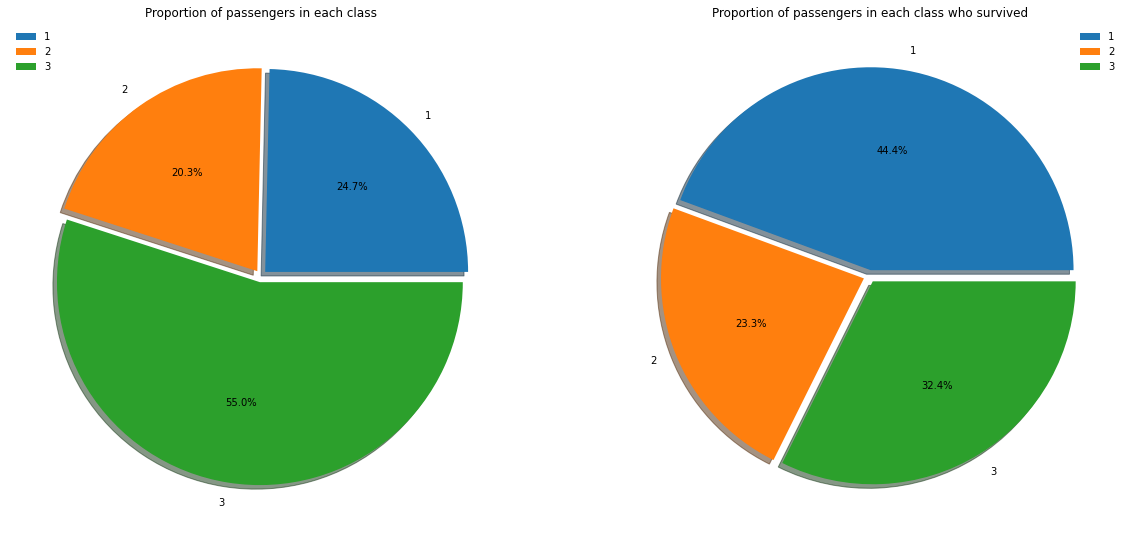

Time: 2.66s.  Time taken to do this by getting the data from the server was 0.88s


In [37]:
f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
start = time.time()
eda = EDAVisualizer(ax1)
ax1, pie_data = eda.pie_plot(data, column="PCLASS", title="Proportion of passengers in each class")
eda = EDAVisualizer(ax2)
ax2, pie_data = eda.pie_plot(data.filter('SURVIVED=1'), column="PCLASS", title="Proportion of passengers in each class who survived")
end = time.time()
plt.show()
print("Time: {}s.  Time taken to do this by getting the data from the server was 0.88s".format(round(end-start, 2)))

### Correlation plot - Look at all numeric columns

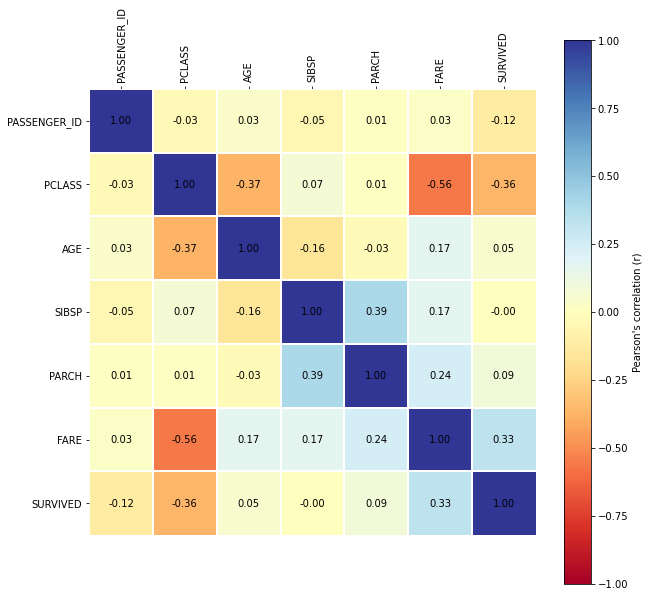

Time: 5.59s.  Time taken to do this by getting the data from the server was 2s


In [38]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(111)
start = time.time()
eda = EDAVisualizer(ax1)
ax1, corr = eda.correlation_plot(data)
end = time.time()
plt.show()
print("Time: {}s.  Time taken to do this by getting the data from the server was 2s".format(round(end-start, 2)))

### Performance Comparison

In [39]:
# Box plot time for the large data set is 1600s!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
col_names =  ['chart', 'dataSize', 'noDataframe', 'withDataframe']
comparison_df  = pd.DataFrame(columns = col_names)
comparison_df.loc[len(comparison_df)] = ['Distribution', '1K',  0.86,  0.14]
comparison_df.loc[len(comparison_df)] = ['Pie', '1K',  0.88,  0.09]
comparison_df.loc[len(comparison_df)] = ['Correlation', '1K',  2.0,   2.78]

comparison_df.loc[len(comparison_df)] = ['Distribution', '8K',  7.5,   0.18]
comparison_df.loc[len(comparison_df)] = ['Pie', '8K',  7.6,   0.26]
comparison_df.loc[len(comparison_df)] = ['Correlation', '8K',  9.2,   2.1]

comparison_df.loc[len(comparison_df)] = ['Distribution', '500K',  360,   0.29]
comparison_df.loc[len(comparison_df)] = ['Pie', '500K',  450,   0.23]
comparison_df.loc[len(comparison_df)] = ['Correlation', '500K',  400,   4.3]

comparison_df.loc[len(comparison_df)] = ['Distribution', '1M',  950,   0.33]
comparison_df.loc[len(comparison_df)] = ['Pie', '1M',  940,   0.22]
comparison_df.loc[len(comparison_df)] = ['Correlation', '1M',  950,   6.28]
comparison_df['noDataframe'] = np.log10(comparison_df['noDataframe']*1000)
comparison_df['withDataframe'] = np.log10(comparison_df['withDataframe']*1000)
#comparison_df[comparison_df['chart'] == 'Distribution']['noDataframe']

<ipython-input-40-fc57bc5aa4aa>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, .01, .1, 1, 10, 100, 1000], fontsize=20)


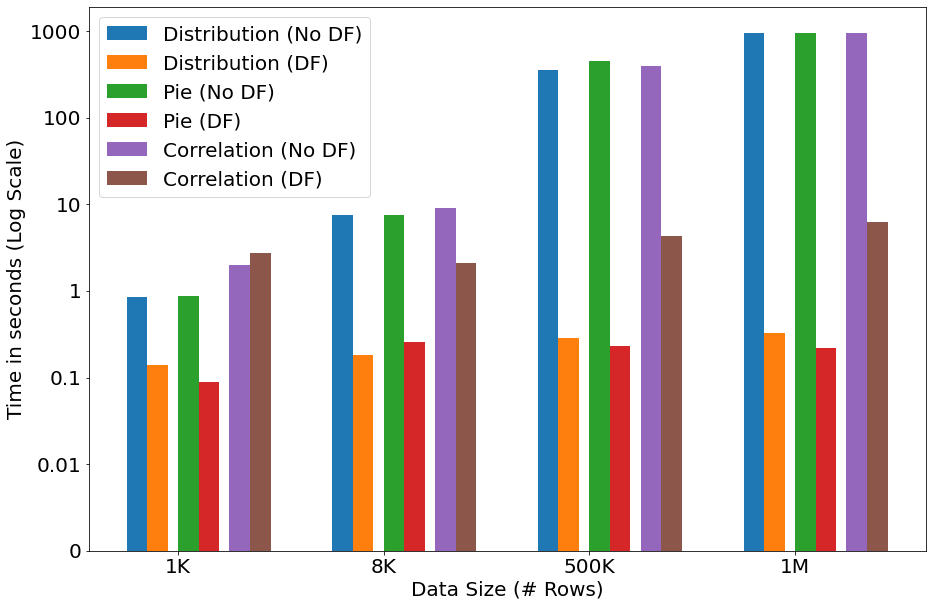

In [40]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
N = 4
width = 0.10
ind = np.arange(N) 
ax.bar(ind,           comparison_df[comparison_df['chart'] == 'Distribution']['noDataframe'], width, label='Distribution (No DF)')
ax.bar(ind +   width, comparison_df[comparison_df['chart'] == 'Distribution']['withDataframe'], width, label='Distribution (DF)')
gap = 0.05
ax.bar(ind + gap + 2*width, comparison_df[comparison_df['chart'] == 'Pie']['noDataframe'], width, label='Pie (No DF)')
ax.bar(ind + gap + 3*width, comparison_df[comparison_df['chart'] == 'Pie']['withDataframe'], width, label='Pie (DF)')

ax.bar(ind + 2*gap + 4*width, comparison_df[comparison_df['chart'] == 'Correlation']['noDataframe'], width, label='Correlation (No DF)')
ax.bar(ind + 2*gap + 5*width, comparison_df[comparison_df['chart'] == 'Correlation']['withDataframe'], width, label='Correlation (DF)')


#plt.ylabel('Scores')
#plt.title('Scores by group and gender')

#ax.xticks(ind + width*2, comparison_df['dataSize'].unique())
ax.set_xticks(ind + width*2)
ax.set_xticklabels(comparison_df['dataSize'].unique(), fontsize=20)
ax.set_xlabel("Data Size (# Rows)", fontsize=20)
ax.set_yticklabels([0, .01, .1, 1, 10, 100, 1000], fontsize=20)
ax.set_ylabel("Time in seconds (Log Scale)", fontsize=20)
ax.legend(loc='best', fontsize=20)
plt.show()

# SUMMARY
## What we covered
<li><b>Dataframes:</b>A reference to a relation in HANA.  No need for deep SQL knowledge.</li>
<li><b>HANA ML API:</b>Exploit HANA's ML capabilities using a SciKit type of Python interface.</li>
<li><b>Exploratory Data Analysis and Visualization:</b>Analyze large data sets without the performance penalty or running out of resources on the client</li>
<br>

## Main benefits
<li>Ease of Use: For the data scientists.</li>
<li>Performance:  Orders of magnitude performance gains.</li>
<li>Security:  Centralized security.</li>
<br>
<br>